In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import test3 as t
import seaborn as sns
%matplotlib inline

## Exploratory Data Analysis

In [233]:
df_S= pd.read_csv('./calendarS.csv')
df_S['month_day']=df_S['date'].str[5:]
df_S.head()

,listing_id,date,available,price,month_day
0,241032,2016-01-04,t,$85.00,01-04
1,241032,2016-01-05,t,$85.00,01-05
2,241032,2016-01-06,f,NaN,01-06
3,241032,2016-01-07,f,NaN,01-07
4,241032,2016-01-08,f,NaN,01-08


In [234]:
df_B= pd.read_csv('./calendarB.csv')
df_B['month_day']=df_B['date'].str[5:]
df_B.head()

,listing_id,date,available,price,month_day
0,12147973,2017-09-05,f,NaN,09-05
1,12147973,2017-09-04,f,NaN,09-04
2,12147973,2017-09-03,f,NaN,09-03
3,12147973,2017-09-02,f,NaN,09-02
4,12147973,2017-09-01,f,NaN,09-01


In [235]:
df_S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
 4   month_day   1393570 non-null  object
dtypes: int64(1), object(4)
memory usage: 53.2+ MB


In [236]:
#Let's clean the data
# 1st price (transform to number)
df_S['price']=df_S['price'].str.replace('$','')
df_S['price']=df_S['price'].str.replace(',','')
df_S['price']=df_S['price'].astype(float)

df_B['price']=df_B['price'].str.replace('$','')
df_B['price']=df_B['price'].str.replace(',','')
df_B['price']=df_B['price'].astype(float)

# 2nd date, group by year-month
df_S['date']=pd.to_datetime(df_S['date'])
df_S['y_m']=df_S['date'].dt.strftime('%Y-%m')

df_B['date']=pd.to_datetime(df_B['date'])
df_B['y_m']=df_B['date'].dt.strftime('%Y-%m')

#df_S.info()

In [237]:
# number of homes during this year
len(pd.unique(df_S['listing_id'])) 

3818

In [238]:
len(pd.unique(df_B['listing_id'])) 

3585

In [239]:
# available homes in Airbnb during the year
df_S_ava=df_S[df_S['available']=='t']
df_S_ga=df_S_ava.groupby(['month_day'])['listing_id'].count()
df_S_ga=df_S_ga.reset_index()
df_S_ga['av']=df_S_ga['listing_id']/len(pd.unique(df_S['listing_id']))
df_S_ga['type']='Seattle'

df_B_ava=df_B[df_B['available']=='t']
df_B_ga=df_B_ava.groupby(['month_day'])['listing_id'].count()
df_B_ga=df_B_ga.reset_index()
df_B_ga['av']=df_B_ga['listing_id']/len(pd.unique(df_B['listing_id']))
df_B_ga['type']='Boston'

In [240]:
df_S_ga['listing_id'].describe()

count     365.000000
mean     2560.389041
std       182.879102
min      1735.000000
25%      2471.000000
50%      2577.000000
75%      2682.000000
max      2922.000000
Name: listing_id, dtype: float64

In [241]:
df_B_ga['listing_id'].describe()

count     365.000000
mean     1761.745205
std       273.240049
min       570.000000
25%      1738.000000
50%      1771.000000
75%      1946.000000
max      2207.000000
Name: listing_id, dtype: float64

In [242]:
df_B_ga.loc[df_B_ga['av']==df_B_ga['av'].max()]

,month_day,listing_id,av,type
337,12-04,2207,0.615621,Boston


In [243]:
print("Percentage available")
print("Seattle:",df_S_ga['listing_id'].mean()/len(pd.unique(df_S['listing_id'])))
print("Boston:",df_B_ga['listing_id'].mean()/len(pd.unique(df_B['listing_id'])))

Percentage available
Seattle: 0.6706100160020666
Boston: 0.4914212567585641


[(0.0, 1.0)]

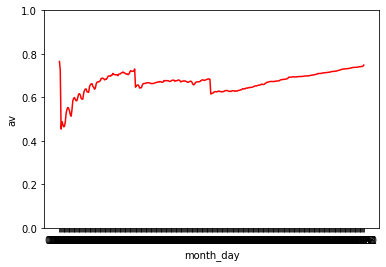

In [244]:
# daily evolution of available homes during 2016
ax=sns.lineplot(data=df_S_ga,x='month_day', y='av', color='red')
ax.set(ylim=(0, 1))

[(0.0, 1.0)]

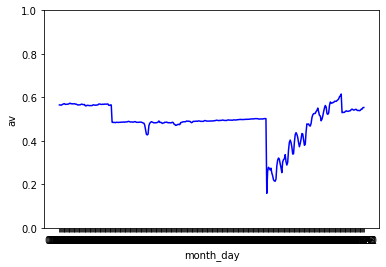

In [245]:
ax=sns.lineplot(data=df_B_ga,x='month_day', y='av', color='blue')
ax.set(ylim=(0, 1))

### distribution of homes availability during the year

In [246]:
# Unavailable homes the entire year
print('homes without any availability in seattle:', len(pd.unique(df_S['listing_id']))-len(pd.unique(df_S_ava['listing_id'])),'/', (len(pd.unique(df_S['listing_id']))-len(pd.unique(df_S_ava['listing_id'])))/len(pd.unique(df_S['listing_id'])) )
print('homes without any availability in boston:', len(pd.unique(df_B['listing_id']))-len(pd.unique(df_B_ava['listing_id'])),'/', (len(pd.unique(df_B['listing_id']))-len(pd.unique(df_B_ava['listing_id'])))/len(pd.unique(df_B['listing_id'])) )

homes without any availability in seattle: 95 / 0.024882137244630696
homes without any availability in boston: 679 / 0.1894002789400279


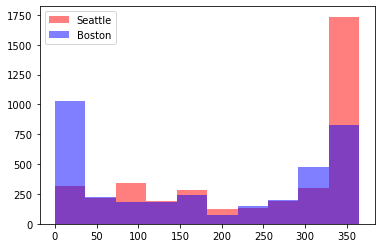

In [247]:
df_B_1=df_B.groupby('listing_id')['price'].count()
df_B_1=df_B_1.reset_index()
df_S_1=df_S.groupby('listing_id')['price'].count()
df_S_1=df_S_1.reset_index()

plt.hist(df_S_1['price'], color='red', label='Seattle', alpha=0.5)
plt.hist(df_B_1['price'], color='blue', label='Boston', alpha=0.5)


plt.legend()
plt.show()


### pricing

In [248]:
# mean price homes in Airbnb during the year
df_S_ga2=df_S_ava.groupby(['month_day'])['price'].mean()
df_S_ga2=df_S_ga2.reset_index()

df_B_ga2=df_B_ava.groupby(['month_day'])['price'].mean()
df_B_ga2=df_B_ga2.reset_index()

In [249]:
df_S_ava['price'].describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

In [250]:
df_B_ava['price'].describe()

count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: price, dtype: float64

In [251]:
print("mean price")
print("Seattle:",df_S_ava['price'].mean())
print("Boston:",df_B_ava['price'].mean())

mean price
Seattle: 137.94485855103355
Boston: 198.43890942511862


[(0.0, 300.0)]

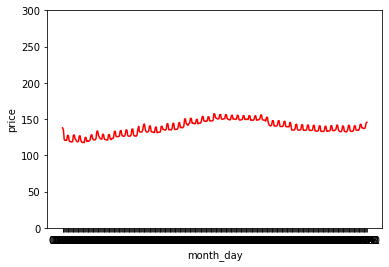

In [252]:
ax=sns.lineplot(data=df_S_ga2,x='month_day', y='price', color='red')
ax.set(ylim=(0, 300))

[(0.0, 300.0)]

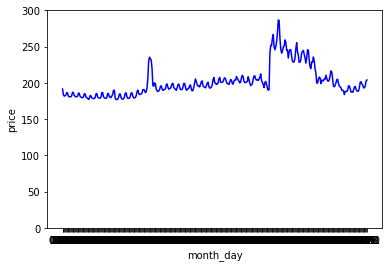

In [253]:
ax=sns.lineplot(data=df_B_ga2,x='month_day', y='price', color='blue')
ax.set(ylim=(0, 300))

## Can we predict or at least say key varibles that change the price?

In [254]:
df_SL= pd.read_csv('./listingsS.csv')
df_SL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [255]:
df_SL.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [256]:
#converto price to float
df_SL['price']=df_SL['price'].str.replace('$','')
df_SL['price']=df_SL['price'].str.replace(',','')
df_SL['price']=df_SL['price'].astype(float)
df_SL['price']

0        85.0
1       150.0
2       975.0
3       100.0
4       450.0
        ...  
3813    359.0
3814     79.0
3815     93.0
3816     99.0
3817     87.0
Name: price, Length: 3818, dtype: float64

In [257]:
df_SL['price'].mean() # average price in the file

127.97616553169199

In [258]:
df_SL.corr()['price']

id                               -0.046289
scrape_id                              NaN
host_id                          -0.051332
host_listings_count               0.093962
host_total_listings_count         0.093962
latitude                         -0.008904
longitude                        -0.102420
accommodates                      0.652218
bathrooms                         0.516424
bedrooms                          0.627720
beds                              0.589525
square_feet                       0.531752
price                             1.000000
guests_included                   0.392875
minimum_nights                    0.017297
maximum_nights                   -0.003336
availability_30                  -0.037653
availability_60                  -0.049336
availability_90                  -0.058810
availability_365                 -0.015550
number_of_reviews                -0.124695
review_scores_rating              0.055551
review_scores_accuracy            0.019026
review_scor

### Let's see explore what variables change the price

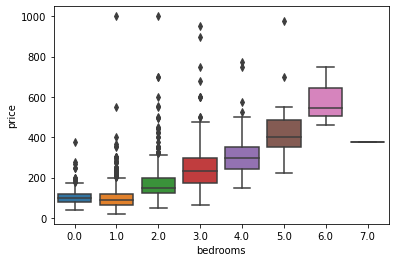

In [259]:
sns.boxplot(y='price',x='bedrooms',data=df_SL)

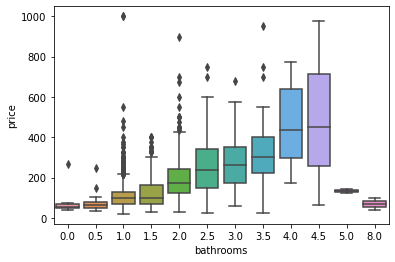

In [260]:
sns.boxplot(y='price',x='bathrooms',data=df_SL)

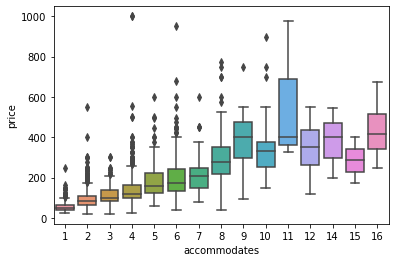

In [261]:
sns.boxplot(y='price',x='accommodates',data=df_SL)

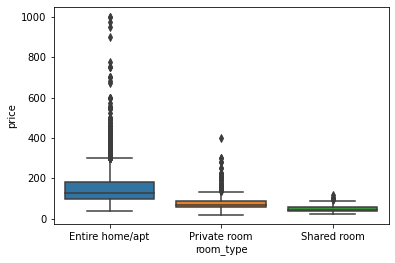

In [262]:
sns.boxplot(y='price',x='room_type',data=df_SL)

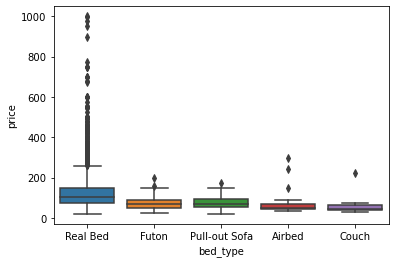

In [263]:
sns.boxplot(y='price',x='bed_type',data=df_SL)

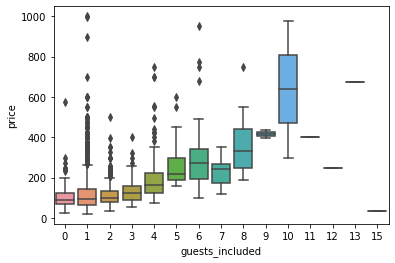

In [264]:
sns.boxplot(y='price',x='guests_included',data=df_SL)

In [265]:
df_analysis=df_SL.dropna(subset=['accommodates',
                                 'bathrooms',
                                 'bedrooms',
                                 'room_type',
                                 'price']) 

In [266]:
X = df_analysis[['accommodates',
                 'bathrooms',
                 'bedrooms',
                     'room_type']]
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,accommodates,bathrooms,bedrooms,room_type_Private room,room_type_Shared room
0,4,1.0,1.0,0,0
1,4,1.0,1.0,0,0
2,11,4.5,5.0,0,0
3,3,1.0,0.0,0,0
4,6,2.0,3.0,0,0


In [267]:
Y = df_analysis['price']

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [269]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [270]:
print(model.intercept_)

39.419664697661446


In [271]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
accommodates,7.803261
bathrooms,31.347372
bedrooms,29.902472
room_type_Private room,-47.276785
room_type_Shared room,-74.178159


In [272]:
predictions = model.predict(X_test)
predictions

array([124.07929099,  86.37355827, 192.99806676, ..., 161.78502371,
       161.78502371, 191.68749567])

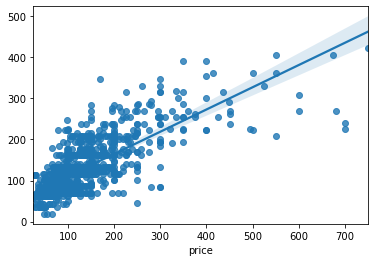

In [273]:
sns.regplot(x=y_test,y=predictions)


In [274]:
r2_score(y_test, predictions)

0.5781815579170664

In [275]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm.astype(float)).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     544.3
Date:                Tue, 29 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:26:56   Log-Likelihood:                -14819.
No. Observations:                2657   AIC:                         2.965e+04
Df Residuals:                    2651   BIC:                         2.968e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     39